<h1> Project : Finding the best locations to Hangout </h1>
    <h2> Country : Singapore </h2>

In [83]:
try:
    import json
    import os
    import geocoder
    import io
    import requests
    import sys
    import pandas as pd
    import urllib.request
    from pandas import json_normalize
    from geopy.geocoders import Nominatim
    import folium
    import numpy as np
    from pandas.io.json import json_normalize
    import matplotlib.cm as cm
    import matplotlib.colors as colors
    from sklearn.cluster import KMeans
    import seaborn as sns
    import matplotlib.pyplot as plt
    from bs4 import BeautifulSoup
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
except ImportError:
    print("ERROR ! Module Import Failed - " + os.path.basename(__file__), "Console")
    print(sys.exc_info())
    input("Press Enter to continue...")
    exit(99)

In [84]:
PlanningArea = []
CLIENT_ID = ''
CLIENT_SECRET = ''

VERSION = '20191231'  # Foursquare API version
radius = 500
LIMIT = 100

OneMapAuth = ""
API_2 = "getSpokenAtHome?"
API_3 = "getEthnicGroup?"
Location = "&planningArea=Bedok"
Year = "&year=2019"
url = "https://developers.onemap.sg/privateapi/popapi/"

QueryLocations = os.getcwd() + "\QueryLocations.csv"
venues = os.getcwd() + "\\venues"

In [101]:
#Supporting Functions
def log_to_report(file, mode, content):
    rf = open(file, "a")
    rf.write(content + "\n")
    rf.close()

def Query(url):
    req = urllib.request.Request(url)
    response = urllib.request.urlopen(req)
    the_page = response.read()
    jason = json.loads(the_page)
    return jason

def QueryLocationData(city, country):
    try:
        geolocator = Nominatim(user_agent="TheProject")
        loc = None
        loc = geolocator.geocode(city + ',' + country)
        if loc is None:
            return "NA", "NA"
        else:
            return loc.latitude, loc.longitude
    except:
        return "NA", "NA"

def jsonwrite(file, content):
    with open(file, 'w') as json_file:
        json.dump(content, json_file)

def ProcessFourSquareData(results):
    venues = results['response']['groups'][0]['items']
    nearby_venues = pd.json_normalize(venues)  # flatten JSON
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues = nearby_venues.loc[:, filtered_columns]
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
    nearby_venues["groupby"] = nearby_venues.apply(get_category_group, axis=1)
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

    return nearby_venues


def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']

    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


def get_category_group(row):
    try:
        categories = row['categories']
    except:
        categories = row['venue.categories']

    if len(categories) == 0:
        return None
    else:
        value = categories

    HOTEL_RESTAURANT = ["noodle", "burger", "subway", "donalds", "hotel", "hotels", "food", "restaurant", "restaurants", "dining", "dine", "cuisine", "salad", "soup", "breakfast", "lunch", "dinner", "pizza", "buffet"]
    SNACK = ["coffee", "tea", "juice", "cafeteria", "cafe", "bakery", "donut", "yogurt", "dessert"]
    BARS = ["bar", "bistro", "brewery", "wine"]
    CLUB = ["club", "nightclub"]
    SHOP = ["cloth", "shop", "market", "jewel", "shoe", "cosmetic", "boutique"]
    ENTERTAINMENT = ["cinema", "multiplex", "art", "scenic", "lighthouse", "theme", "movie"]
    if [ele for ele in HOTEL_RESTAURANT if (ele in str(value).lower())]:
        return "Restaurant"
    elif [ele for ele in SNACK if (ele in str(value).lower())]:
        return "Quick Bite"
    elif [ele for ele in BARS if (ele in str(value).lower())]:
        return "Bars"
    elif [ele for ele in CLUB if (ele in str(value).lower())]:
        return "Club"
    elif [ele for ele in SHOP if (ele in str(value).lower())]:
        return "Shop"
    elif [ele for ele in ENTERTAINMENT if (ele in str(value).lower())]:
        return "Entertainment"
    else:
        return "Misc."
    
def GetWeatherData(Weather_Data):
    Orchard_dict = {}

    for metadata in Weather_Data['area_metadata']:
        name = metadata['name']
        lat = metadata['label_location']['latitude']
        lon = metadata['label_location']['longitude']
        Orchard_dict[name] = mpu.haversine_distance((ClarkQuay_lat, ClarkQuay_lon), (lat, lon))

    O_min = min(Orchard_dict.keys(), key=(lambda k: Orchard_dict[k]))
    print("Location Closer To Orchard    : " + O_min)

    WeatherForecast = []
    for items in Weather_Data['items']:
        for forecasts in items["forecasts"]:
            if forecasts["area"] == O_min:
                mystring = forecasts["area"] + "->" + forecasts["forecast"]
                if not mystring in WeatherForecast:
                    WeatherForecast.append(mystring)

    for value in WeatherForecast:
        print(value)

def GetPollutionIndex(Data):
    Orchard_dict = {}
    for metadata in Data['region_metadata']:
        name = metadata['name']
        lat = metadata['label_location']['latitude']
        lon = metadata['label_location']['longitude']
        Orchard_dict[name] = mpu.haversine_distance((ClarkQuay_lat, ClarkQuay_lon), (lat, lon))

    O_min = min(Orchard_dict.keys(), key=(lambda k: Orchard_dict[k]))

    print("Area Orchard Belongs To    : " + O_min)
    for items in Data['items']:
        my_dict = items['readings']['pm25_one_hourly']
        for Location, PI in my_dict.items():
            if Location == O_min:
                if float(PI) > 0 and float(PI) <= 12:
                    Result = "Good"
                elif float(PI) > 12 and float(PI) <= 35.4:
                    Result = "Moderate"
                else:
                    Result = "Un-Healthy"
                print('Location : {} -> Pollution Index PM2.5 {} and is {}'.format(Location, PI, Result))
                
def GetTopTenRestaurants(loc, url, clas):
    page = requests.get(url)
    data = page.text
    soup = BeautifulSoup(data,"lxml")
    print("Query Link  : " + url)
    print("Query Title : " + soup.find('title').text)

    restaurant_list = []
    restaurant_info = []
    for link in soup.find_all(class_=clas):
        restaurant = str(link.text).rstrip()
        restaurant_list.append(restaurant)
    
    restaurant_data = []
    for span in soup.find_all('span', {'class': '_1p0FLy4t'}):
        ratings = str(span.text).rstrip()
        if "reviews" in ratings:
            restaurant_info.append((",".join(restaurant_data)))
            restaurant_data = []
        else:
            ratings = ratings.replace(", ","&")
            restaurant_data.append(ratings)
    
    Restaurants = []    
    for res in range(0, len(restaurant_list)):
        if restaurant_list[res][0].isdigit():
            Name = restaurant_list[res].split(". ")
            Info = restaurant_info[res]
            Restaurants.append(str(Name[0]) + "," + Name[1] + "," + Info)
        else:
            continue
    
    OutputFile = os.getcwd() + "\\" + loc + ".csv"
    os.remove(OutputFile)
    log_to_report(OutputFile, "w+", "Rank,Restaurant Name,Operating,Cuisine,Cost Range")
    for topten in range(0, len(Restaurants)):
        log_to_report(OutputFile, "a", Restaurants[topten])
    
    return OutputFile

<h2> 1.	Getting list of locations in Singapore </h2><br>

<li> To get this data, we use API from OneMapSG that provides list of PlanningAreaNames </li>
<li> Further geolocator module is used to retrieve the locations Latitude and Longitude </li>
<li> Locations with No LATLON information is excluded and the final output is saved in a CSV </li>


In [4]:
print(">>> Action 1 : QueryLocations")
api = "getPlanningareaNames?"
myurl = url + api + OneMapAuth
log_to_report(QueryLocations, "w", "Location ID, Location Name, Latitude, Longitude")
for value in Query(myurl):
    my_dict = dict(value)
    location = str(my_dict['pln_area_n'])
    lat, lon = QueryLocationData(location, "Singapore")
    if lat == "NA" or lon == "NA":
        continue
    else:
        log_to_report(QueryLocations, "a", str(my_dict['id']) + "," + location + "," + str(lat) + "," + str(lon))
        PlanningArea.append(my_dict['pln_area_n'])

print(">>> Action 1 : Done !!!")
print(">>> Total Locations In Singapore : " + str(len(PlanningArea) + 1))


>>> Action 1 : QueryLocations
>>> Action 1 : Done !!!
>>> Total Locations In Singapore : 53


<h2> 2. Mapping the locations to enable visualization </h2><br>
<li> To visualize the locations on Singapore Map we use the Folium Module </li>

In [95]:
df = pd.read_csv(QueryLocations)
address = 'Singapore, SG'

geolocator = Nominatim(user_agent="TheProject")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Singapore are {}, {}.'.format(latitude, longitude))

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
kclusters = 5
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(df[' Latitude'], df[' Longitude'], df[' Location Name']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The geograpical coordinate of Singapore are 1.357107, 103.8194992.


<h2> 3. Explore the venues near the location </h2> <br>
<li> Using FourSquare "explore" API to find out list of all areas in and around each and every location in Singapore </li>

In [96]:
print(">>> Action 2 : QueryFourSquare")
print(">>> Reading File Into Data Frame : " + QueryLocations)
FourSquare = []
PrimeLocations = []
for index, row in df.iterrows():
    if "#" in str(df['Location ID'][index]):
        continue
    Location = df[' Location Name'][index]
    LatValue = df[' Latitude'][index]
    LonValue = df[' Longitude'][index]
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            LatValue,
            LonValue,
            radius,
            LIMIT)
    results = requests.get(url).json()

    if "There aren't a lot of results near you" in str(results["response"]):
        FourSquare.append("No")
        continue
    else:
        FourSquare.append("Yes")
        jsonwrite(venues + "\\" + str(Location) + ".json", results)
        FSQ_DF = ProcessFourSquareData(results)
        FSQ_DF.to_csv(venues + "\\" + str(Location) + "_FSQ.csv")

    print('    $ Exploring Location {}, Containing Total of {} places nearby'.format(Location, str(FSQ_DF.shape[0])))
    if int(FSQ_DF.shape[0]) == int(LIMIT):
        PrimeLocations.append(Location)
        
    
df["FourSquare"] = FourSquare
print(">>> Action 2 : Done !!!")

>>> Action 2 : QueryFourSquare
>>> Reading File Into Data Frame : C:\Users\User\Documents\GitHub\BattleOfNeighCapStone\QueryLocations.csv
    $ Exploring Location SOUTHERN ISLANDS, Containing Total of 9 places nearby
    $ Exploring Location SUNGEI KADUT, Containing Total of 4 places nearby
    $ Exploring Location NEWTON, Containing Total of 22 places nearby
    $ Exploring Location ORCHARD, Containing Total of 100 places nearby
    $ Exploring Location KALLANG, Containing Total of 7 places nearby
    $ Exploring Location PASIR RIS, Containing Total of 34 places nearby
    $ Exploring Location STRAITS VIEW, Containing Total of 93 places nearby
    $ Exploring Location MARINA EAST, Containing Total of 4 places nearby
    $ Exploring Location MARINA SOUTH, Containing Total of 4 places nearby
    $ Exploring Location SERANGOON, Containing Total of 41 places nearby
    $ Exploring Location BOON LAY, Containing Total of 69 places nearby
    $ Exploring Location BEDOK, Containing Total of 6

<h3> The Prime Locations Are !!! </h3>

In [97]:
for Loc in PrimeLocations:
    print(Loc)

ORCHARD
SINGAPORE RIVER


<h2>4.	Visualizing Selected Locations To Explore Further </h2><br>
<p> We will be exploring these two neighborhoods to understand the following factors </p>
<li> Number of places available to hangout in the Selected Prime Locations are Visualized </li>


In [87]:
SgRiver_df = pd.read_csv(venues + "\\SINGAPORE RIVER_FSQ.csv")
Orchard_df = pd.read_csv(venues + "\\ORCHARD_FSQ.csv")
address = 'Clark Quay, SG'

geolocator = Nominatim(user_agent="TheProject")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Singapore are {}, {}.'.format(latitude, longitude))

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=14)
for lat, lon, poi in zip(SgRiver_df['lat'], SgRiver_df['lng'], SgRiver_df['name']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# add markers to the map
for lat, lon, poi in zip(Orchard_df['lat'], Orchard_df['lng'], Orchard_df['name']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color="red",
        fill=True,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The geograpical coordinate of Singapore are 1.28895695, 103.84649610611979.


<h2> 5.	Grouping Venues </h2> <br>
<p> Since our customer is more of exploring and trying to spend time leisurely, we try to group the venues in the following categories only </p>
    <li>Restaurant</li>
    <li>Bar</li>
    <li>Club</li>
    <li>Quick Bite</li>
    <li>Entertainment</li>
    <li>Shop</li>
    <li>Misc.</li>
<br>
<p>Assumption : </p><br>
<li>If customer is willing to spend his day time - He can opt for venues under Restaurant, Shop, Entertainment</li>
<li>If customer is willing to spend his Night time - He can opt for venues under Restaurant, Bar, Club</li>

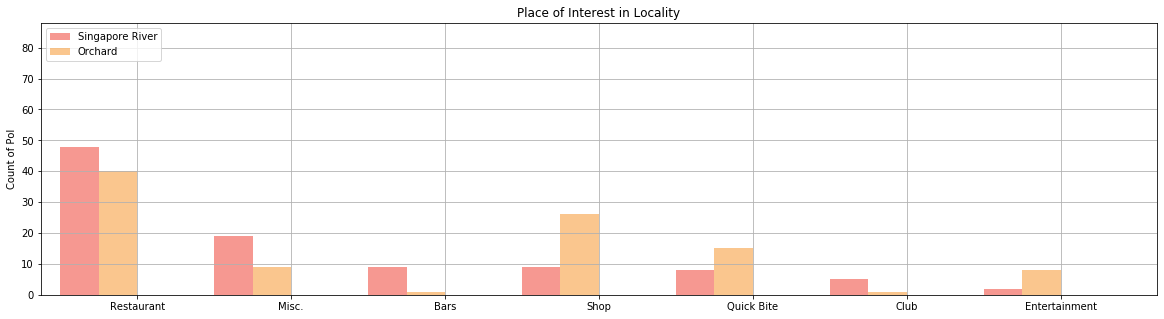

In [88]:
df_1 = pd.DataFrame(SgRiver_df['groupby'].value_counts())
df_1.columns = ['Singapore River']
df_2 = pd.DataFrame(Orchard_df['groupby'].value_counts())
df_2.columns = ['Orchard']
df = pd.concat([df_1, df_2], axis=1, ignore_index=False)
df.reset_index(inplace=True)

pos = list(range(len(df['Singapore River']))) 
width = 0.25 
fig, ax = plt.subplots(figsize=(20,5))
plt.bar(pos, 
        df['Singapore River'], 
        width, 
        alpha=0.5, 
        color='#EE3224', 
        label=df['Singapore River'][0])

plt.bar([p + width for p in pos], 
        df['Orchard'],
        width, 
        alpha=0.5, 
        color='#F78F1E', 
        label=df['Orchard'][1]) 

ax.set_ylabel('Count of PoI')
ax.set_title('Place of Interest in Locality')
ax.set_xticks([p + 1.5 * width for p in pos])
ax.set_xticklabels(df['index'])
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, max(df['Singapore River'] + df['Orchard'])] )
plt.legend(['Singapore River', 'Orchard'], loc='upper left')
plt.grid()
plt.show()

<h2> 6.	Finalizing a Location based on Supporting Data </h2><br>
    <li>Explore : Venues @ Orchard</li>
    <li>Time : Day Time </li>

In [103]:
Orchard = 'Orchard, SG'
geolocator = Nominatim(user_agent="TheProject")
location = geolocator.geocode(Orchard)
Orchard_lat = round(location.latitude, 3)
Orchard_lon = round(location.longitude, 3)
print("Orchard    : " + str(Orchard_lat) + "," + str(Orchard_lon))

Orchard    : 1.305,103.833


<h2>7.	Providing More Data to validate his choice of location</h2><br>
<p> Now that our customer has selected Orchard to explore, let's give him more information on what he can expect for his exploration </p>

In [106]:
from datetime import date
from datetime import datetime
import mpu
today = date.today()
time = datetime.now()
date = today.strftime("%Y-%m-%d")
time = time.strftime("%H:%M:%S")
date_time = date + "T" + time

print("Full Day Weather : " )
URL = "https://api.data.gov.sg/v1/environment/2-hour-weather-forecast?date=" + str(date)
GetWeatherData(Query(URL))
print("")

print("Current Weather Info : Time - " + str(date_time).replace("T", " "))
URL = "https://api.data.gov.sg/v1/environment/2-hour-weather-forecast?date_time=" + str(date_time)
GetWeatherData(Query(URL))
print("")

print("Pollution Index Info : ")
URL = "https://api.data.gov.sg/v1/environment/pm25?date_time=" + str(date_time)
GetPollutionIndex(Query(URL))
print("")


Full Day Weather : 
Location Closer To Orchard    : City
City->Partly Cloudy (Night)
City->Fair (Night)
City->Fair (Day)
City->Fair & Warm

Current Weather Info : Time - 2020-03-17 22:50:34
Location Closer To Orchard    : City
City->Fair (Night)

Pollution Index Info : 
Area Orchard Belongs To    : south
Location : south -> Pollution Index PM2.5 11 and is Good



<h2>8.	Recommending him a Restaurant</h2><br>

Query Link  : https://www.tripadvisor.com.sg/Restaurants-g294265-zfn15622523-Singapore.html
Query Title :  10 Best Clarke Quay Restaurants (Singapore) - Tripadvisor 
Output File : C:\Users\User\Documents\GitHub\BattleOfNeighCapStone\Orchard.csv



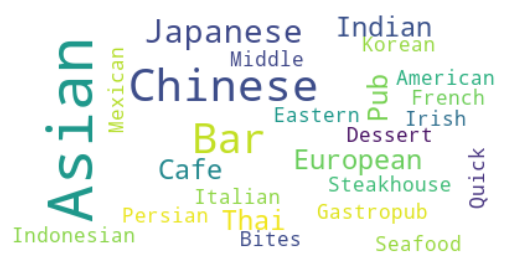

Top 10 Restaurants :
                  Restaurant Name         Operating
0  The RANCH Steakhouse By ASTONS        Closed Now
1                Haidilao Hot Pot          Open Now
2      Sque Rotisserie & Alehouse          Open Now
3        RAS The Essence of India          Open Now
4    Violet Oon Satay Bar & Grill  Closes in 26 min
5                          Bayang        Closed Now
6      Brewerkz (Riverside Point)          Open Now
7                 McGettigan's CQ          Open Now
8                     Cafe Iguana          Open Now
9        Ellenborough Market Cafe          Open Now


In [119]:
#Trending Places near each location
url = 'https://www.tripadvisor.com.sg/Restaurants-g294265-zfn15622523-Singapore.html'
Class = "_15_ydu6b"
Orchard =  GetTopTenRestaurants("Orchard", url, Class)
print("Output File : " + Orchard + "\n")
Orchard_DF = pd.read_csv(Orchard)

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(Orchard_DF['Cuisine'].values).replace("'",""))
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

print("Top 10 Restaurants :")
print(Orchard_DF[['Restaurant Name','Operating']].head(10))


<h2> Inference </h2> <br>
<li> The recommender system identifies "Orchard" as his location of Interest and provides top restaurants he can visit to spend his time </li>